# Ingesting Housing Market Data from SNB

Data is Housing Price Index from SNB. All values are relative to year 2000 prices (2000 = 100%)

In [29]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    # Get the JSON data
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Extract values | Each row are the values for a different property type and data provider
        values_df = pd.DataFrame(series['values'])
        
        # Add metadata columns
        values_df['property_type'] = property_type
        values_df['data_provider'] = data_provider
        
        # Dont need these columns
        #values_df['unit'] = series['metadata']['unit']
        #values_df['frequency'] = series['metadata']['frequency']
        
        # Append to our list
        all_series.append(values_df)
    
    # Combine all series into one DataFrame
    base_df = pd.concat(all_series, ignore_index=True)
    
    # Convert date column to datetime
    base_df['date'] = pd.to_datetime(base_df['date'], format='%Y')
    
    # Convert value column to numeric
    base_df['value'] = pd.to_numeric(base_df['value'])
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

,date,value,property_type,data_provider
0,2017-01-01,94.052037,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
1,2018-01-01,96.735820,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
2,2019-01-01,100.000000,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
3,2020-01-01,102.185954,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...
4,2021-01-01,107.784384,Residential property prices - Privately owned ...,Swiss Federal Statistical Office - Transaction...


In [5]:
print("unique property types:")
for type in base_df['property_type'].unique():
    print(type)
print('='*100)

print("unique data providers:")
for provider in base_df['data_provider'].unique():
    print(provider)
print('='*100)

unique property types:
Residential property prices - Privately owned apartments
Residential property prices - Single-family houses
Residential property prices - Apartment buildings (residential investment property)
Rents - Rental housing units
Rents - Office space
Rents - Industrial and commercial space
Rents - Retail space
unique data providers:
Swiss Federal Statistical Office - Transaction price
Fahrländer Partner - Transaction price
IAZI - Transaction price
Wüest Partner - Asking price
Wüest Partner - Transaction price


All data is stacked one collumn for the value but there are:
- different property types (Residential property vs. Rents) and (Privately owned appartments vs. Single-family houses)
- different data providers (OFS vs Wuest vs IAZI) and price type (Asking price vs. Transaction price)

for the purpose of predicting the housing market, we want to have a dataframe that has:
- One column for the asking price and one for the transaction price
- One column residential property prices and one for rents by asking price or transaction price
- average together the data providers by price type and property type

Let's start by parsing the data into unique columns



In [30]:
import pandas as pd
import requests
import json

try:
    # Get the data from the SNB API
    url = r"https://data.snb.ch/api/cube/plimoincha/data/json/en"
    response = requests.get(url)
    response.raise_for_status()
    
    data = response.json()
    
    # Initialize an empty list to store all timeseries data
    all_series = []
    
    # Process each timeseries
    for series in data['timeseries']:
        # Extract header information
        property_type = series['header'][0]['dimItem']
        data_provider = series['header'][1]['dimItem']
        
        # Create a DataFrame from the values
        df = pd.DataFrame(series['values'])
        
        # Create a descriptive column name from property type and data provider
        column_name = f"{property_type} - {data_provider}"
        
        # Convert the values to numeric
        df['value'] = pd.to_numeric(df['value'])
        
        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'], format='%Y')
        
        # Add to list with series information
        all_series.append((df, column_name))
    
    # Start with the first series to get all dates
    base_df = all_series[0][0][['date']].copy()
    
    # Add each series as a new column
    for df, column_name in all_series:
        base_df = base_df.merge(
            df[['date', 'value']], 
            on='date', 
            how='outer'
        )
        base_df = base_df.rename(columns={'value': column_name})
    
    # Sort by date
    base_df = base_df.sort_values('date')
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    base_df = None
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    base_df = None
except Exception as e:
    print(f"Error processing data: {e}")
    base_df = None

base_df.head()

,date,Residential property prices - Privately owned apartments - Swiss Federal Statistical Office - Transaction price,Residential property prices - Privately owned apartments - Fahrländer Partner - Transaction price,Residential property prices - Privately owned apartments - IAZI - Transaction price,Residential property prices - Privately owned apartments - Wüest Partner - Asking price,Residential property prices - Privately owned apartments - Wüest Partner - Transaction price,Residential property prices - Single-family houses - Swiss Federal Statistical Office - Transaction price,Residential property prices - Single-family houses - Fahrländer Partner - Transaction price,Residential property prices - Single-family houses - IAZI - Transaction price,Residential property prices - Single-family houses - Wüest Partner - Asking price,Residential property prices - Single-family houses - Wüest Partner - Transaction price,Residential property prices - Apartment buildings (residential investment property) - Fahrländer Partner - Transaction price,Residential property prices - Apartment buildings (residential investment property) - IAZI - Transaction price,Residential property prices - Apartment buildings (residential investment property) - Wüest Partner - Transaction price,Rents - Rental housing units - Wüest Partner - Asking price,Rents - Office space - Wüest Partner - Asking price,Rents - Industrial and commercial space - Wüest Partner - Asking price,Rents - Retail space - Wüest Partner - Asking price
0,1970-01-01,NaN,NaN,NaN,37.067421,NaN,NaN,NaN,NaN,36.476339,NaN,NaN,NaN,NaN,34.664977,48.588164,46.120740,57.492516
1,1971-01-01,NaN,NaN,NaN,40.041925,NaN,NaN,NaN,NaN,41.771233,NaN,NaN,NaN,NaN,40.164850,52.454522,54.266010,54.101961
2,1972-01-01,NaN,NaN,NaN,45.192274,NaN,NaN,NaN,NaN,50.331605,NaN,NaN,NaN,NaN,45.606831,59.946112,56.381710,72.492423
3,1973-01-01,NaN,NaN,NaN,51.021098,NaN,NaN,NaN,NaN,59.446265,NaN,NaN,NaN,NaN,50.334182,64.896925,66.659691,76.553432
4,1974-01-01,NaN,NaN,NaN,50.419630,NaN,NaN,NaN,NaN,59.588616,NaN,NaN,NaN,NaN,53.390472,65.482283,63.007929,72.950228


## Defining some cleaning functions

In [63]:
def import_snb_housing_data(url="https://data.snb.ch/api/cube/plimoincha/data/json/en"):
    try:
        # Get the data from the SNB API
        response = requests.get(url)
        response.raise_for_status()
        
        data = response.json()
        
        # Initialize an empty list to store all timeseries data
        all_series = []
        
        # Process each timeseries
        for series in data['timeseries']:
            # Extract header information
            property_type = series['header'][0]['dimItem']
            data_provider = series['header'][1]['dimItem']
            
            # Create a DataFrame from the values
            df = pd.DataFrame(series['values'])
            
            # Create a descriptive column name from property type and data provider
            column_name = f"{property_type} - {data_provider}"
            
            # Convert the values to numeric
            df['value'] = pd.to_numeric(df['value'])
            
            # Convert date to datetime
            df['date'] = pd.to_datetime(df['date'], format='%Y')
            
            # Add to list with series information
            all_series.append((df, column_name))
        
        # Start with the first series to get all dates
        base_df = all_series[0][0][['date']].copy()
        
        # Add each series as a new column
        for df, column_name in all_series:
            base_df = base_df.merge(
                df[['date', 'value']], 
                on='date', 
                how='outer'
            )
            base_df = base_df.rename(columns={'value': column_name})
        
        # Sort by date
        base_df = base_df.sort_values('date')
        return base_df
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None
    

def remove_sfso_data(df):
    """
    Remove Swiss Federal Statistical Office data from the DataFrame
    """
    # Get columns that don't contain 'Swiss Federal Statistical Office'
    non_sfso_cols = [col for col in df.columns 
                     if 'Swiss Federal Statistical Office' not in col or col == 'date']
    
    return df[non_sfso_cols]

def split_residental_rents(df):

    # Get all columns that contain 'Residential property prices'
    residential_prices = [col for col in df.columns if 'Residential property prices' in col]
    
    # Create a new DataFrame with only the residential prices
    residential_df = pd.concat([df['date'], df[residential_prices]], axis=1)

    # Get all columns that contain 'Rents'
    rents = [col for col in df.columns if 'Rents' in col]

    # Create a new DataFrame with only the rents
    rents_df = pd.concat([df['date'], df[rents]], axis=1)

    return residential_df, rents_df
    

def average_providers(residential_df):
    
    types = {
        'Residential property prices': ['Privately owned apartments', 'Single-family houses', 'Apartment buildings (residential investment property)'],
        'data_provider': ['Fahrländer Partner', 'IAZI', 'Wüest Partner'],
        'price_type': ['Asking price', 'Transaction price'],
    }
    
    # Initialize the averaged DataFrame with the date column
    averaged_df = pd.DataFrame({'date': residential_df['date']})
    
    # For each property type
    for property_type in types['Residential property prices']:
        # For each price type (asking vs transaction)
        for price_type in types['price_type']:
            # Create the pattern to match columns
            pattern = f"{property_type}"  # Simplified pattern matching
            price_pattern = 'Asking price' if 'Asking' in price_type else 'Transaction price'
            
            # Get all columns that match this pattern (will catch different providers)
            matching_cols = [col for col in residential_df.columns 
                           if pattern in col and price_pattern in col]
            
            if matching_cols:
                # Create a temporary DataFrame with just the matching columns
                temp_df = residential_df[matching_cols]
                
                # Count non-NaN values for each row
                #non_nan_count = temp_df.notna().sum(axis=1)
                
                # Calculate row-wise mean (this automatically ignores NaN values)
                row_means = temp_df.mean(axis=1)
                
                # Create column name
                col_name = f"{property_type} - {price_type}"
                
                # Add both the average and the count of providers to the DataFrame
                averaged_df[col_name] = row_means
                #averaged_df[f"{col_name} - Provider Count"] = non_nan_count
    
    return averaged_df

def stack_columns(df):
    """
    Function to stack columns and create a single dataframe with both asking and transaction prices
    aligned by date and property type.
    Returns a dataframe with columns: date, property_type, asking_price, transaction_price
    """
    # Initialize empty lists to store dataframes
    asking_price_dfs = []
    transaction_price_dfs = []
    
    for col in df.columns:
        if col == 'date':
            continue
            
        # Extract the property type by removing the price type suffix
        property_type = col.split(' - ')[0]  # Takes the first part before " - "
        
        # Create temporary dataframe with date and price
        temp_df = pd.concat([df['date'], df[col]], axis=1)
        
        if 'Asking price' in col:
            # Rename the price column to asking_price
            temp_df = temp_df.rename(columns={col: 'asking_price'})
            temp_df['property_type'] = property_type
            asking_price_dfs.append(temp_df)
        elif 'Transaction price' in col:
            # Rename the price column to transaction_price
            temp_df = temp_df.rename(columns={col: 'transaction_price'})
            temp_df['property_type'] = property_type
            transaction_price_dfs.append(temp_df)
    
    # Stack all asking price dataframes
    asking_prices_df = pd.concat(asking_price_dfs, ignore_index=True)
    # Stack all transaction price dataframes
    transaction_prices_df = pd.concat(transaction_price_dfs, ignore_index=True)
    
    # Merge the two dataframes on date and property_type
    combined_df = pd.merge(
        asking_prices_df, 
        transaction_prices_df, 
        on=['date', 'property_type'], 
        how='outer'
    )
    
    # Sort by date and property_type
    combined_df = combined_df.sort_values(['date', 'property_type'])
    
    # Rename Appartement buildings value
    combined_df['property_type'] = combined_df['property_type'].replace({'Apartment buildings (residential investment property)' : 'Appartment buildings'})
    
    return combined_df

def join_rents(combined_df, rents_df):
     
     # First let's rename the rents DF columns
     for col in rents_df.columns:
          if col == 'date':
               continue
          name = col.split('-')
          name = ('-').join(name[0:2])
          rents_df = rents_df.rename(columns={col: name})
     
     # Now let's join both DFs together

     housing_df = pd.merge(
          left = combined_df, 
          right = rents_df, 
          on = 'date',
          how = 'outer'
          )
     
     return housing_df
    
def get_clean_housing_data(url="https://data.snb.ch/api/cube/plimoincha/data/json/en"):
    base_df = import_snb_housing_data(url)
    cleaned_df = remove_sfso_data(base_df)
    residential_df, rents_df = split_residental_rents(cleaned_df)
    averaged_df = average_providers(residential_df)
    combined_df = stack_columns(averaged_df)
    housing_df = join_rents(combined_df, rents_df)
    
    return {
        'base_df': base_df,
        'cleaned_df': cleaned_df,
        'residential_df': residential_df,
        'rents_df': rents_df,
        'averaged_df': averaged_df,
        'combined_df': combined_df,
        'housing_df': housing_df
    }


In [65]:
dfs = get_clean_housing_data()
housing_df = dfs['housing_df']
housing_df

,date,asking_price,property_type,transaction_price,Rents - Rental housing units,Rents - Office space,Rents - Industrial and commercial space,Rents - Retail space
0,1970-01-01,NaN,Appartment buildings,NaN,34.664977,48.588164,46.120740,57.492516
1,1970-01-01,37.067421,Privately owned apartments,NaN,34.664977,48.588164,46.120740,57.492516
2,1970-01-01,36.476339,Single-family houses,NaN,34.664977,48.588164,46.120740,57.492516
3,1971-01-01,NaN,Appartment buildings,NaN,40.164850,52.454522,54.266010,54.101961
4,1971-01-01,40.041925,Privately owned apartments,NaN,40.164850,52.454522,54.266010,54.101961
...,...,...,...,...,...,...,...,...
160,2023-01-01,187.658501,Privately owned apartments,240.258694,142.719131,118.597196,117.251560,111.548723
161,2023-01-01,189.898192,Single-family houses,213.819478,142.719131,118.597196,117.251560,111.548723
162,2024-01-01,NaN,Appartment buildings,163.797819,149.401432,117.903731,119.401059,111.641745
163,2024-01-01,188.501891,Privately owned apartments,247.621496,149.401432,117.903731,119.401059,111.641745


## Plotting the Data and Descriptive Statistics

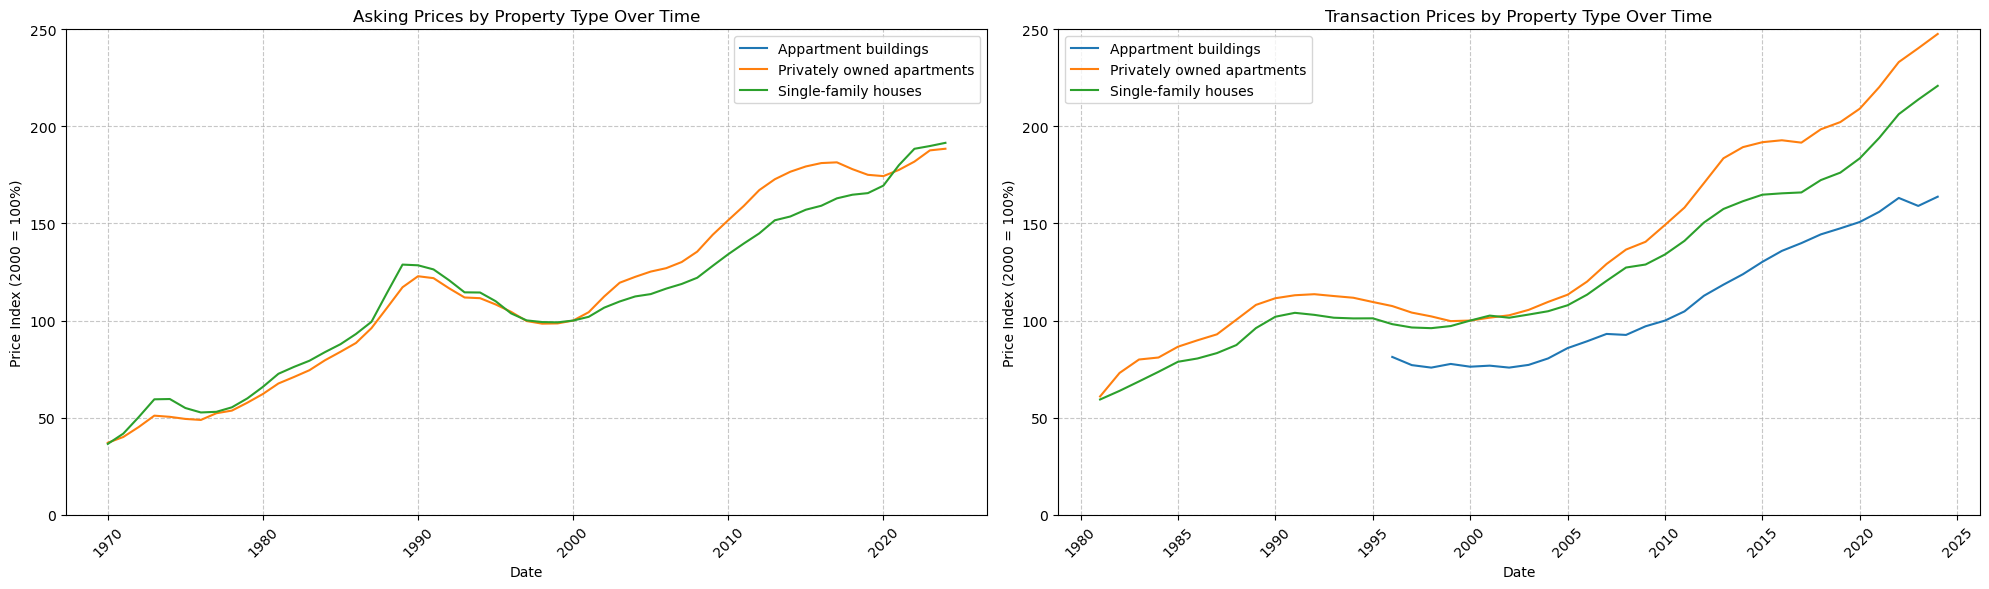

In [58]:
import matplotlib.pyplot as plt

# 1. Convert the 'date' column to datetime
housing_df['date'] = pd.to_datetime(housing_df['date'])

# 2. Define the three property types (make sure these match exactly!)
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create figure and axes for two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot - Asking Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax1.plot(data['date'], data['asking_price'], label=property_type)

# Customize first subplot
ax1.set_title('Asking Prices by Property Type Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price Index (2000 = 100%)')
ax1.set_ylim(0,250)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Second subplot - Transaction Prices
for property_type in property_types:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    ax2.plot(data['date'], data['transaction_price'], label=property_type)

# Customize second subplot
ax2.set_title('Transaction Prices by Property Type Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Index (2000 = 100%)')
ax2.set_ylim(0,250)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

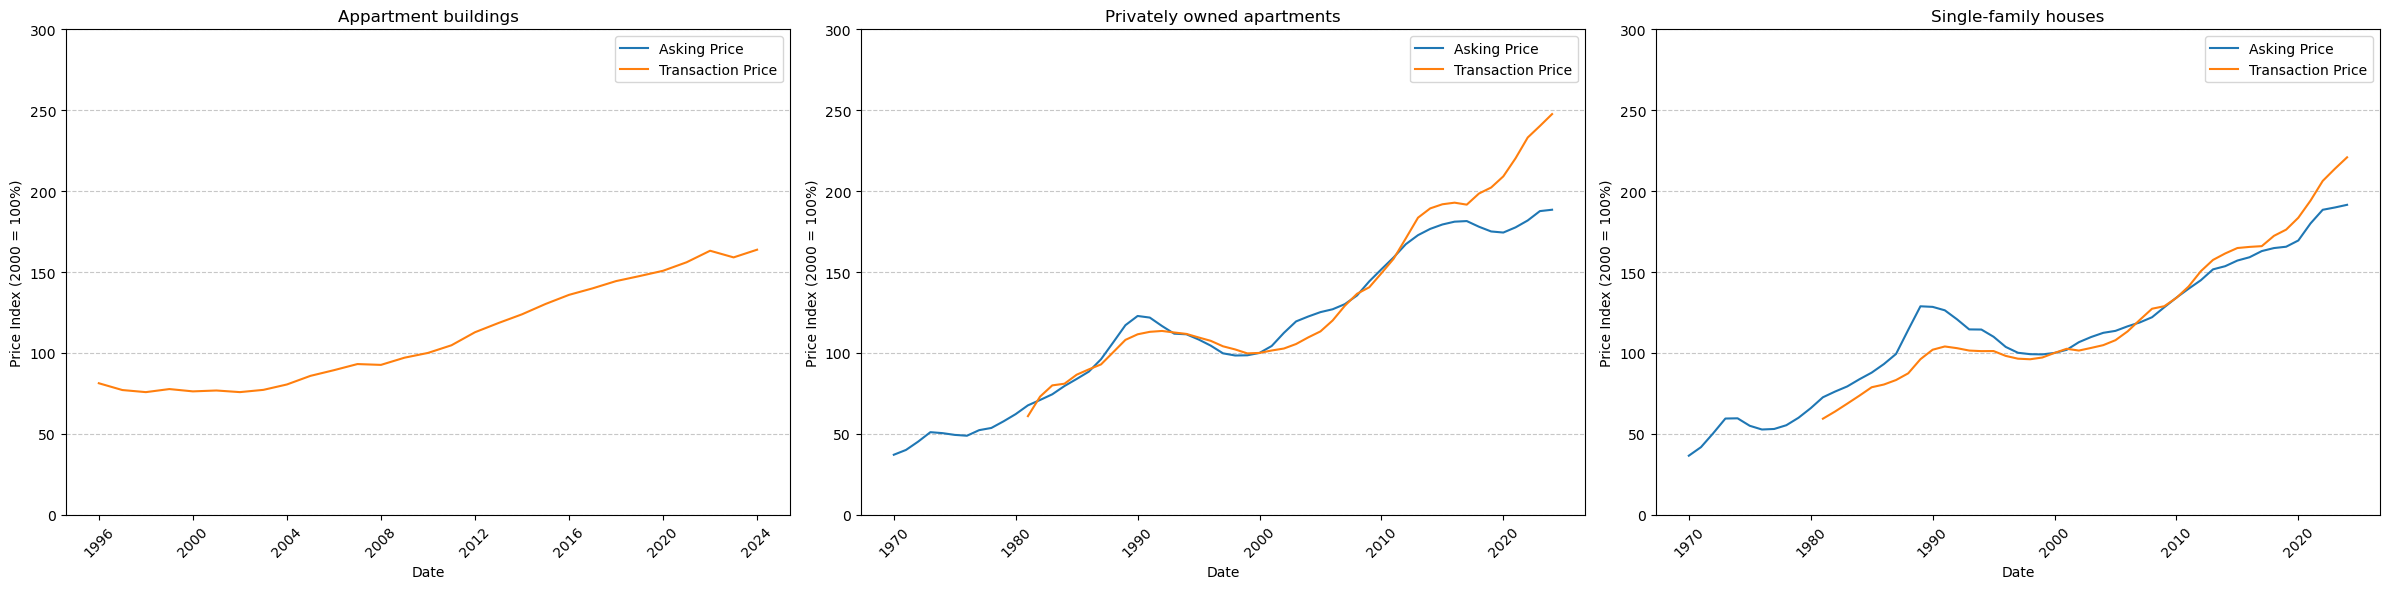

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axes for three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Define the property types
property_types = []
for types in housing_df['property_type'].unique():
    property_types.append(types)

# Create a dictionary mapping axes to property types for cleaner code
ax_property_pairs = [
    (ax1, property_types[0]),
    (ax2, property_types[1]),
    (ax3, property_types[2])
]

# Plot each property type in its own subplot
for ax, property_type in ax_property_pairs:
    mask = housing_df['property_type'] == property_type
    data = housing_df[mask].sort_values('date')
    
    # Plot both asking and transaction prices
    ax.plot(data['date'], data['asking_price'], label='Asking Price')
    ax.plot(data['date'], data['transaction_price'], label='Transaction Price')
    
    # Customize subplot
    ax.set_title(f'{property_type}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price Index (2000 = 100%)')
    ax.set_ylim([0, 300])
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

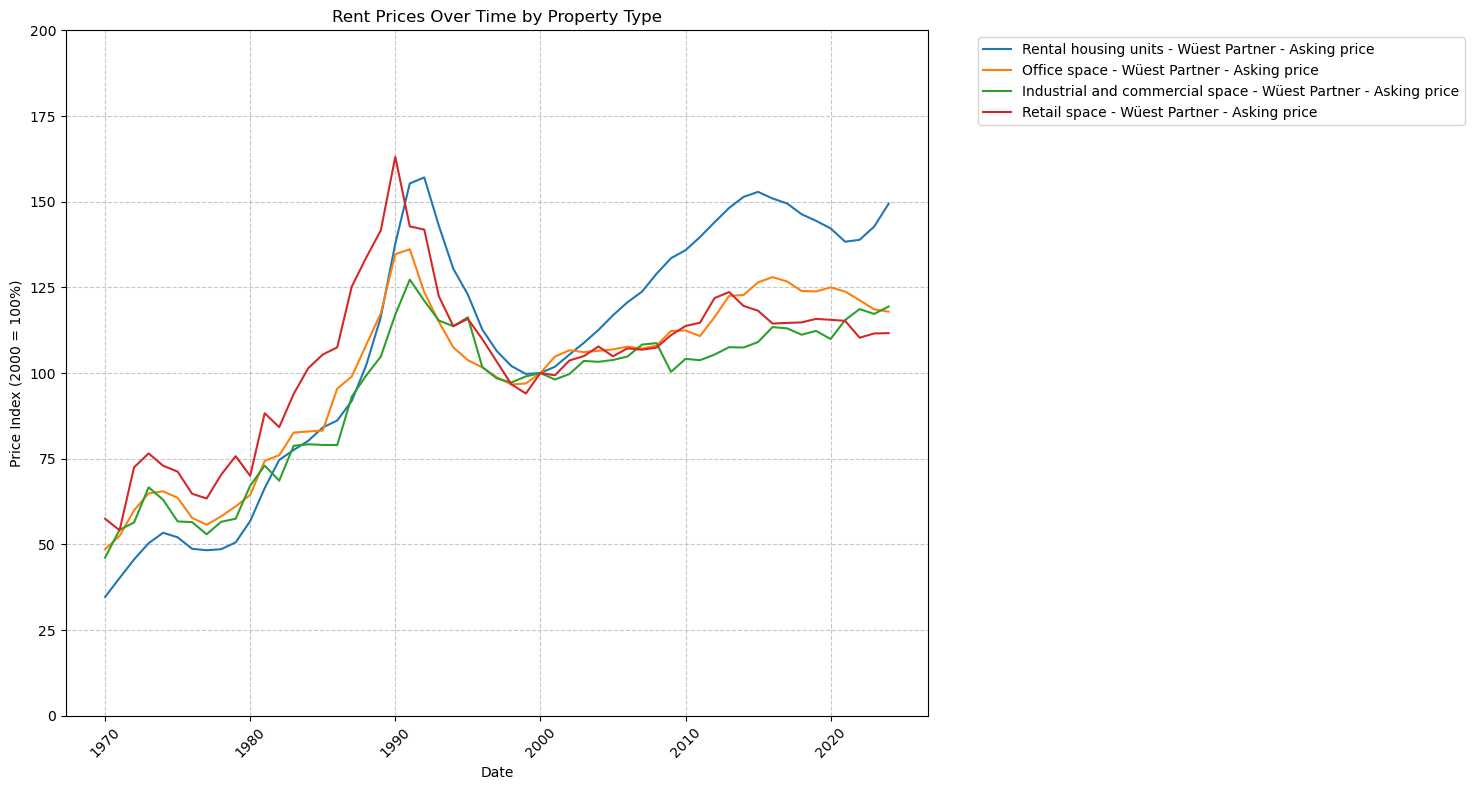

In [84]:
import matplotlib.pyplot as plt

rents_df = dfs['rents_df']

# Create figure and axis
plt.figure(figsize=(15, 8))

# Plot each rent type
rent_columns = []

for col in rents_df.columns:
    if col == 'date':
        continue
    rent_columns.append(col)

for column in rent_columns:
    plt.plot(rents_df['date'], rents_df[column], label=column.replace('Rents - ', ''))

# Customize plot
plt.title('Rent Prices Over Time by Property Type')
plt.xlabel('Date')
plt.ylabel('Price Index (2000 = 100%)')
plt.ylim([0, 200])
plt.yticks(range(0, 201, 25))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='x', rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [69]:
averaged_df = dfs['averaged_df']
rents_df = dfs['rents_df']

statistics_df = pd.concat([averaged_df, rents_df])

statistics_df.describe()

,date,Privately owned apartments - Asking price,Privately owned apartments - Transaction price,Single-family houses - Asking price,Single-family houses - Transaction price,Apartment buildings (residential investment property) - Transaction price,Rents - Rental housing units - Wüest Partner - Asking price,Rents - Office space - Wüest Partner - Asking price,Rents - Industrial and commercial space - Wüest Partner - Asking price,Rents - Retail space - Wüest Partner - Asking price
count,110,55.000000,44.000000,55.000000,44.000000,29.000000,55.000000,55.000000,55.000000,55.000000
mean,1996-12-31 14:50:10.909090944,114.179179,136.271265,111.350553,122.951590,110.578202,107.325324,99.493931,94.437113,104.042377
min,1970-01-01 00:00:00,37.067421,60.920272,36.476339,59.350776,75.768477,34.664977,48.588164,46.120740,54.101961
25%,1983-04-02 06:00:00,76.986206,101.989638,81.523272,96.984675,80.498467,78.881088,82.780355,78.886086,93.966269
50%,1997-01-01 00:00:00,111.889770,112.836369,112.424393,103.539813,100.000000,112.672272,106.645840,103.265784,107.498908
75%,2010-10-01 18:00:00,155.373856,185.025848,136.926460,158.481267,139.899647,140.950721,118.250464,110.555780,115.378562
max,2024-01-01 00:00:00,188.501891,247.621496,191.537261,220.900243,163.797819,157.069721,136.112678,127.254825,163.074886
std,NaN,46.340399,50.118778,40.936351,42.094341,31.690167,37.511768,24.390612,22.198375,22.685333


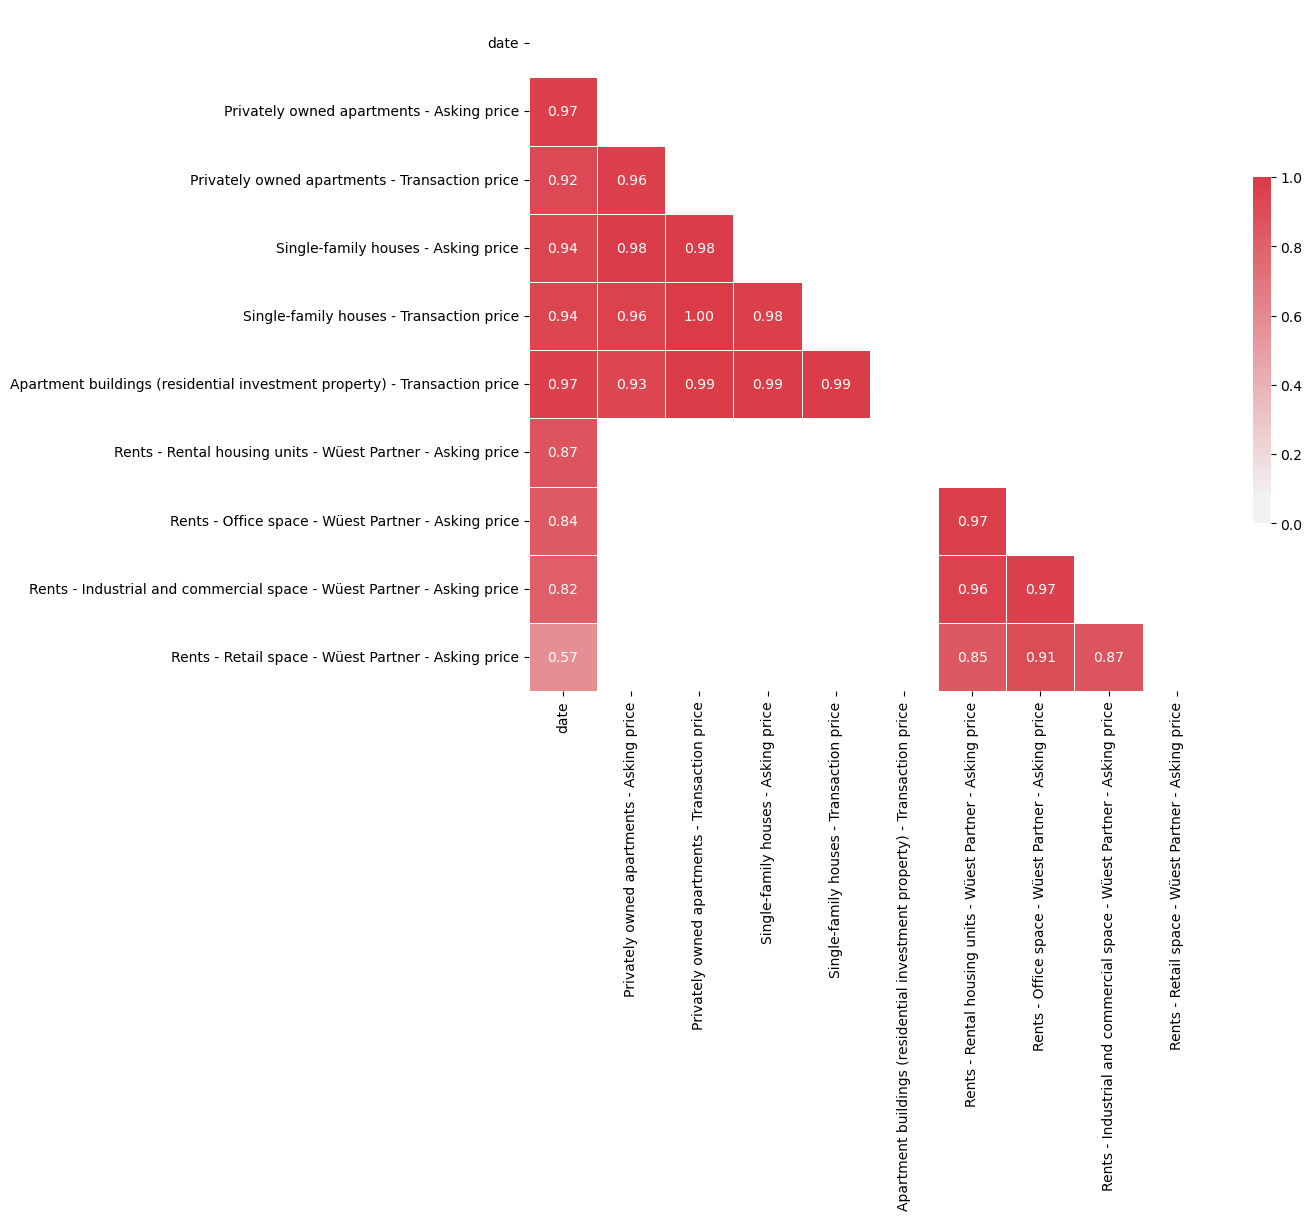

In [78]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

corr = statistics_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(240,10, sep=20,as_cmap=True)

# Add annot=True to display the correlation values
# fmt='.2f' rounds to 2 decimal places
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmin=0,
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={'shrink':.5},
            annot=True,
            fmt='.2f')

plt.show()


# Importing Second Dataset:
Live births  
Deaths  
Natural Change  
Immigration  
Emigration  
Net migration  
Acquisition of Swiss citizenship

In [5]:
import requests
import pandas as pd
from io import StringIO

def get_demographics_data(url="https://dam-api.bfs.admin.ch/hub/api/dam/assets/32229365/master"):
    try:
        # Get the data from the API
        response = requests.get(url)
        response.raise_for_status() 
        
        # Convert the response content to a string buffer
        content = StringIO(response.text)
        
        # Read the CSV from the string buffer
        raw_demographics_df = pd.read_csv(content)

    except requests.exceptions.RequestException as e:
        print(f'Request error: {e}')
    except pd.errors.EmptyDataError as e:
        print(f'CSV parsing error: {e}')
    except Exception as e:
        print(f'An error occurred: {e}')
    
    return raw_demographics_df

def long_to_wide_demographics(raw_demographics_df):
    colname = raw_demographics_df.columns[0]
    raw_demographics_df=raw_demographics_df.rename(columns={colname: 'date'})
    
    component_key = {
        'LIVB': 'Live births',
        'DTH': 'Deaths',
        'NC': 'Natural Change',
        'IMMI': 'Immigration',
        'EMI': 'Emigration',
        'NMIG': 'Net migration',
        'ACQCH': 'Acquisition of Swiss citizenship',
        'STATADJ': 'Statistical adjustments'
    }
    
    raw_demographics_df['POPULATION_CHANGE_COMPONENT'] = raw_demographics_df['POPULATION_CHANGE_COMPONENT'].map(component_key)
    
    # Using pivot_table to handle duplicate values (if any)
    demographics_df = raw_demographics_df.pivot_table(
        index='date',
        columns='POPULATION_CHANGE_COMPONENT',
        values='VALUE',
        aggfunc='first'  # or 'mean', 'sum', etc. depending on what you want to do with duplicates
    ).reset_index()
    
    return demographics_df

In [6]:
raw_demographics_df = get_demographics_data()
raw_demographics_df

,"ï»¿""YEAR""",POPULATION_CHANGE_COMPONENT,VALUE,OBS_STATUS
0,1861,LIVB,74820.0,A
1,1862,LIVB,75870.0,A
2,1863,LIVB,79160.0,A
3,1864,LIVB,79600.0,A
4,1865,LIVB,78290.0,A
...,...,...,...,...
1299,2019,STATADJ,-238.0,A
1300,2020,STATADJ,744.0,A
1301,2021,STATADJ,1168.0,A
1302,2022,STATADJ,-112.0,A


In [8]:
demographics_df = long_to_wide_demographics(raw_demographics_df)
demographics_df

POPULATION_CHANGE_COMPONENT,date,Acquisition of Swiss citizenship,Deaths,Emigration,Immigration,Live births,Natural Change,Net migration,Statistical adjustments
0,1861,NaN,57520.0,NaN,NaN,74820.0,17300.0,381.0,NaN
1,1862,NaN,51070.0,NaN,NaN,75870.0,24800.0,-3620.0,NaN
2,1863,NaN,54360.0,NaN,NaN,79160.0,24800.0,-3408.0,NaN
3,1864,NaN,59500.0,NaN,NaN,79600.0,20100.0,-1194.0,NaN
4,1865,NaN,59090.0,NaN,NaN,78290.0,19200.0,-2653.0,NaN
...,...,...,...,...,...,...,...,...,...
158,2019,41127.0,67780.0,126221.0,169573.0,86172.0,18392.0,43352.0,-238.0
159,2020,34141.0,76195.0,109376.0,163180.0,85914.0,9719.0,53804.0,744.0
160,2021,36994.0,71192.0,116769.0,165640.0,89644.0,18452.0,48871.0,1168.0
161,2022,41486.0,74425.0,122123.0,190883.0,82371.0,7946.0,68760.0,-112.0
